# Multi-class Classification of Anonymized 'Adult' Dataset - Logistic Regression

This notebook presents classification of Adult dataset. Classification is done using logistic regression on target attribute 'education-num'. 
 <ol>
    <li>In the first part we predict 'education-num' based on original data</li>
    <li>In the second part we use 3-anonymous data obtained with ARX tool
        <ul>
            <li>partial anonymization with defined hierarchies
            <li>partial anonymization without defined hierarchies
            <li>partial anonymization only for **non-countinuous** data with defined hierarchies
        </ul>
    </li>
    <li>In the last part we compare performances on all other chosen k-values</li>
  </ol>
Anonymization done without any defined hierarchies means that all the attributes have two levels of anonymity: non-anonymous(original value) and completely anonymous(\*). Furthermore, the used partial anonymization means that it is possible to anonymize only part of a single column.

## 1. Classification of Original Data Using Logistic Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn import metrics, preprocessing, model_selection
from sklearn.linear_model import LogisticRegression

In [3]:
# reads the data from the csv file with specific filepath
def read_anon_data(k):
    directory = "../../data/ARX/without-hierarchies/adult_k"
    ext = ".csv"
    filepath = directory + str(k) + ext
    dataset = pd.read_csv(filepath, sep=r'\s*,\s*', na_values="*", engine='python')
    return dataset

# import non-anonymized dataset
dataset = read_anon_data(1)
dataset.head(20)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,3,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,3,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,2,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,2,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,3,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Non-US,<=50K
5,37,Private,284582,4,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,2,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Non-US,<=50K
7,52,Self-emp-not-inc,209642,2,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,4,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,3,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


We will use *education-num* as a target for our classification task. Instead of 16 continuous levels, we will define clustering into 4 classes: "elementary-school", "high-school", "gollege-bachelors", "advanced-studies".

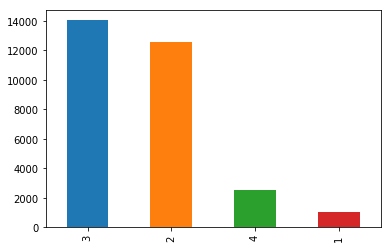

In [4]:
dataset['education-num'].value_counts().plot(kind='bar')

We are using Logistic Regression classifier which requires numerical data. We want to avoid missleading information that enumerated categorical data can give so we are using binary data. For example, race would be encoded into some numbers and bigger values will suggest that they have bigger importance than some other, when in reality all values of race are treated as equal.

In [5]:
binary_data = pd.get_dummies(dataset)
binary_data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Non-US,native-country_United-States,income_<=50K,income_>50K
0,39,77516,3,2174,0,40,0,0,0,0,...,0,0,0,1,0,1,0,1,1,0
1,50,83311,3,0,0,13,0,0,0,0,...,0,0,0,1,0,1,0,1,1,0
2,38,215646,2,0,0,40,0,0,1,0,...,0,0,0,1,0,1,0,1,1,0
3,53,234721,2,0,0,40,0,0,1,0,...,0,1,0,0,0,1,0,1,1,0
4,28,338409,3,0,0,40,0,0,1,0,...,0,1,0,0,1,0,1,0,1,0


Following plot shows the correlation between 'dummy' attributes.

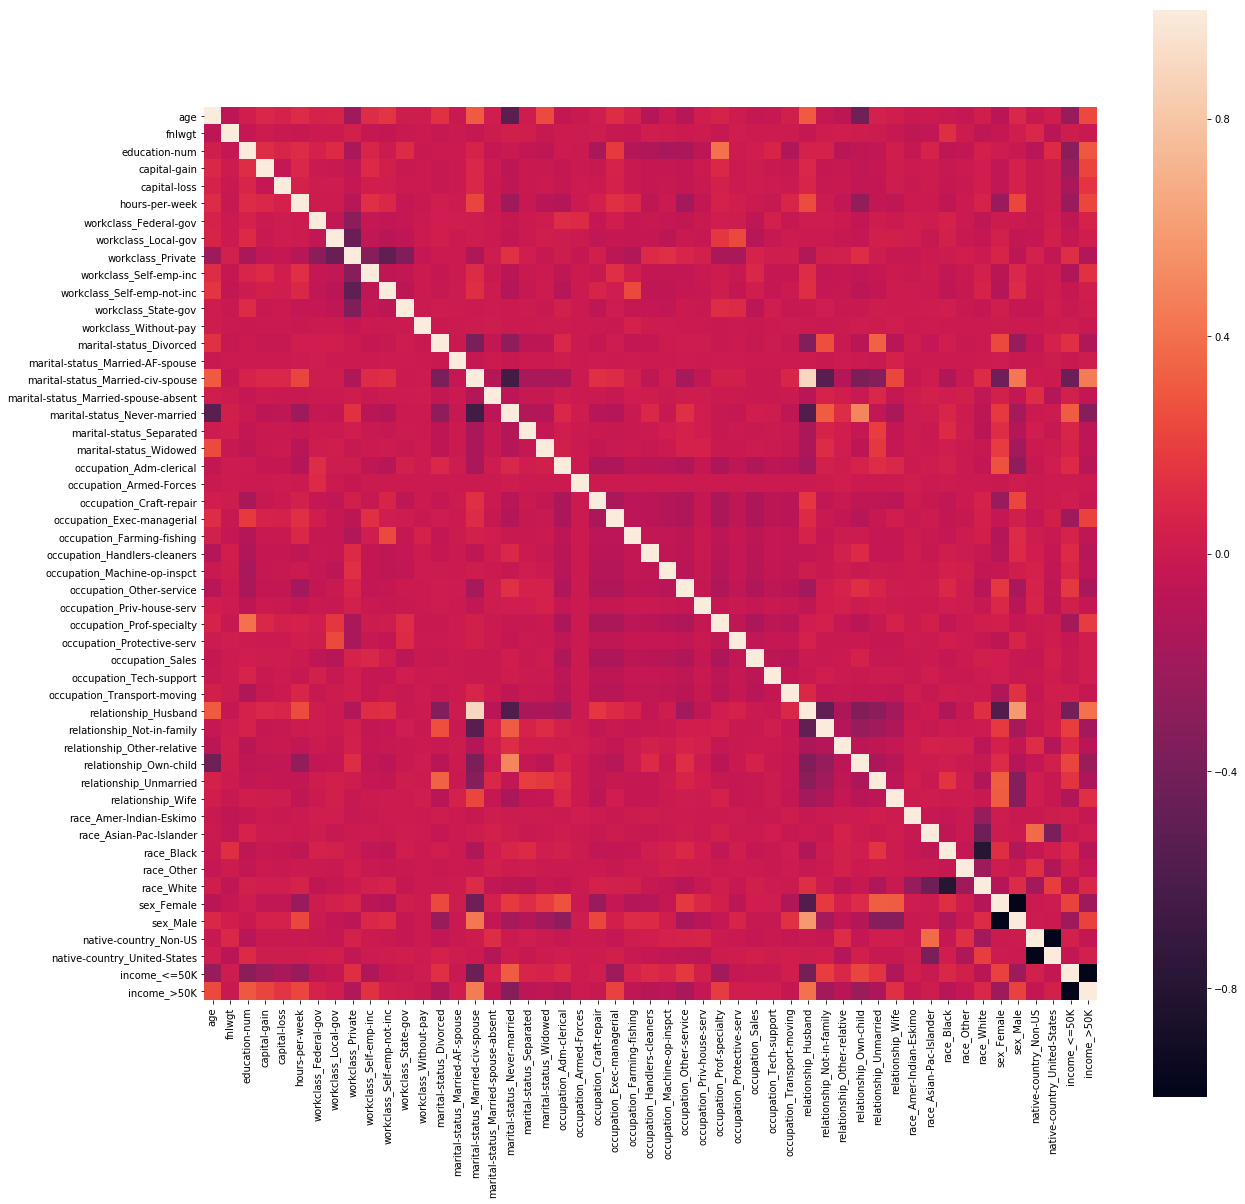

In [6]:
plt.subplots(figsize=(20,20))
sns.heatmap(binary_data.corr(), square=True)

In [7]:
# define target value
y = binary_data['education-num']
X = binary_data.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.shape

(30162, 50)

In [8]:
# define classifier
clf = LogisticRegression(random_state=0, solver='lbfgs')

In [9]:
# cross validation scores 
scores = model_selection.cross_val_score(clf, X, y, cv=10, scoring='f1_micro')
print("F1 score: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

# prediction
predicted = model_selection.cross_val_predict(clf, X, y, cv=10)
f1_k1 = metrics.f1_score(y, predicted, average='micro')

F1 score: 0.61 (+/- 0.02)


This is nice f1 score :)

In [10]:
metrics.accuracy_score(y, predicted)

0.6146807240899145

In [11]:
metrics.confusion_matrix(y, predicted)

array([[  78,  854,  107,    2],
       [  63, 8464, 3978,   35],
       [  20, 4348, 9347,  322],
       [   0,  103, 1790,  651]], dtype=int64)

## 2. 3-anonymous data classification using Logistic Regression

We check performance of 3-anonymous data obtained with ARX tool with three following settings:
<ol>
<li>partial anonymization with defined hierarchies
<li>partial anonymization without defined hierarchies
<li>partial anonymization only for non-countinuous data with defined hierarchies

### 2.1. Partial anonymization with defined hierarchies

In [12]:
def number_encode_features(ds):
    result = ds.copy()
    encoders = {}
    for feature in result.columns:
        if result.dtypes[feature] == np.object:
            encoders[feature] = preprocessing.LabelEncoder()
            result[feature] = encoders[feature].fit_transform(result[feature].astype(str))
    return result, encoders

In [14]:
#read data
dataset = pd.read_csv("../../data/ARX/multi-class-edu/adult_k3.csv", 
                      sep=r'\s*,\s*', na_values="*", engine='python')

# preprocess
del dataset['fnlwgt']
dataset_encoded, encoders = number_encode_features(dataset)

# define target value
y = dataset_encoded['education-num']
X = dataset_encoded.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# cross validation scores 
scores = model_selection.cross_val_score(clf, X, y, cv=10, scoring='f1_micro')
print("F1 score: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

# prediction
predicted = model_selection.cross_val_predict(clf, X, y, cv=10)
metrics.f1_score(y, predicted, average='micro')

F1 score: 0.44 (+/- 0.10)


0.44254359790464826

In [15]:
dataset.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,NaN,NaN,3,NaN,NaN,NaN,NaN,Female,0,0,NaN,Non-US,<=50K
1,NaN,NaN,3,NaN,NaN,NaN,NaN,Female,0,0,NaN,Non-US,<=50K
2,NaN,NaN,2,NaN,NaN,NaN,NaN,Female,0,0,NaN,Non-US,<=50K
3,NaN,NaN,2,NaN,NaN,NaN,NaN,Male,0,0,NaN,Non-US,<=50K
4,NaN,NaN,3,NaN,NaN,NaN,NaN,Male,0,2179,NaN,Non-US,<=50K


### 2.2. Partial anonymization without hierarchies

In [16]:
# import 3-anonymous dataset
k = 3
dataset = read_anon_data(k) 
dataset.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,42.0,Federal-gov,NaN,3,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40.0,United-States,<=50K
1,42.0,Federal-gov,NaN,2,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40.0,United-States,<=50K
2,42.0,Federal-gov,NaN,2,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40.0,United-States,<=50K
3,37.0,Local-gov,NaN,3,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40.0,United-States,<=50K
4,37.0,Local-gov,NaN,2,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40.0,United-States,<=50K


Data is previously 3-anonymized using ARX. Local transformation was performed giving 3-anonymous dataset with values in columns anonymized to different values. Therefore, attribute *race* is in first 17 rows anonymized entirely, and form 18th row on the values are present. Similarily we have the same thing for other attributes.

We will treat the completely anonymized values as missing values, which potentially creates the problem. Let's first see the distributions to see what we are dealing with.

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
age               7585 non-null float64
workclass         7585 non-null object
fnlwgt            0 non-null float64
education-num     30162 non-null int64
marital-status    7585 non-null object
occupation        7585 non-null object
relationship      7585 non-null object
race              7585 non-null object
sex               7585 non-null object
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    7585 non-null float64
native-country    7585 non-null object
income            7585 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 2.3+ MB


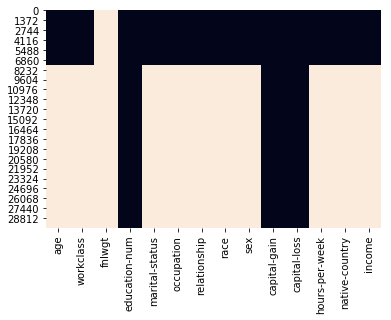

In [18]:
sns.heatmap(dataset.isnull(), cbar=False)

We see that in *occupation* we have a significant loss of the values, but in the other attributes results are fairly good. We can remove completely anonymized column *fnlwgt*

In [19]:
del dataset['fnlwgt']
dataset['age'] = dataset['age'].astype(object)
dataset['hours-per-week'] = dataset['hours-per-week'].astype(object)
dataset.shape

(30162, 13)

We will again group our education values and transfer attributes to binary/encode categorical features with numbers.

In [20]:
# OPTION 1 use binary data for classification - worked better with the original data
# binary_data = pd.get_dummies(dataset)
# binary_data.head()

# OPTION 2 use number encoded features
dataset_encoded, encoders = number_encode_features(dataset)

In this case we have much more attributes than with non-anonymized data because we have introduced some new values during anonymization process. Now we have values from multiple levels of anonymization occuring for a single attribute. Thsi leads to havin ga sparse input matrix.

In [21]:
# define target value
y = dataset_encoded['education-num']
X = dataset_encoded.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.shape

(30162, 12)

In [22]:
# cross validation scores 
scores = model_selection.cross_val_score(clf, X, y, cv=10, scoring='f1_micro')
print("F1 score: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

# prediction
predicted = model_selection.cross_val_predict(clf, X, y, cv=10)
f1_k3 = metrics.f1_score(y, predicted, average='micro')

F1 score: 0.45 (+/- 0.15)


Let's try option 1.

In [23]:
# OPTION 1 use binary data for classification - worked better with the original data
binary_data = pd.get_dummies(dataset)
binary_data.head()

,education-num,capital-gain,capital-loss,age_17.0,age_18.0,age_19.0,age_20.0,age_21.0,age_22.0,age_23.0,...,hours-per-week_44.0,hours-per-week_45.0,hours-per-week_48.0,hours-per-week_50.0,hours-per-week_55.0,hours-per-week_60.0,native-country_Non-US,native-country_United-States,income_<=50K,income_>50K
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [24]:
# define target value
y_bin = binary_data['education-num']
X_bin = binary_data.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X_bin = pd.DataFrame(scaler.fit_transform(X_bin), columns=X_bin.columns)
X_bin.shape

(30162, 111)

In [25]:
# cross validation scores 
scores = model_selection.cross_val_score(clf, X_bin, y_bin, cv=10, scoring='f1_micro')
print("F1 score: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

# prediction
predicted = model_selection.cross_val_predict(clf, X_bin, y_bin, cv=10)
metrics.f1_score(y_bin, predicted, average='micro')

F1 score: 0.44 (+/- 0.13)


0.4445991645116372

We can stick to number-encoded features.

F1 score for this case seems fine, almost the same as case 1. The important insight here is that for the value of k > 23 data is already completely anonymized and useless.

### 2.3. Partial anonymization on non-continuous attributes

In [27]:
#read data
dataset = pd.read_csv("../../data/ARX/without-contin-hie/adult_k3_done.csv", 
                      sep=r'\s*,\s*', na_values="*", engine='python')

# preprocess
dataset_encoded, encoders = number_encode_features(dataset)

# define target value
y = dataset_encoded['education-num']
X = dataset_encoded.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# define classifier
clf = LogisticRegression(random_state=0, solver='lbfgs')

# cross validation scores 
scores = model_selection.cross_val_score(clf, X, y, cv=10, scoring='f1_micro')
print("F1 score: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

# prediction
predicted = model_selection.cross_val_predict(clf, X, y, cv=10)
metrics.f1_score(y, predicted, average='micro')

F1 score: 0.44 (+/- 0.13)


0.43882474295411433

## Performance comparison

In this part we will perform anonymization using ARX on the adult dataset for a range of values of k: 3,7,11,15,19,23,27,31,35,100. We will continue to perform multi-class classification with target *education-num* clustered in 4 groups, and using Logistic Regression, as described in 2.1. and 2.3., respectively.

In [28]:
# define k-s
# import data
# (remove useless columns)
# group education values
# encode features
# define target value
# scale
# cross validation prediction
# store f1 value

k_values = [1, 3, 7, 11, 15, 19, 23, 27, 31, 35, 100]
f1_scores1 = [0.6146807240899145]
f1_scores_bin = [0.6146807240899145]
f1_scores2 = [0.6146807240899145]

for k in k_values:
    if k is 1:
        continue
    dataset1 = pd.read_csv("../../data/ARX/multi-class-edu/adult_k" + str(k) + ".csv", 
                      sep=r'\s*,\s*', na_values="*", engine='python')
    dataset2 = pd.read_csv("../../data/ARX/without-contin-hie/adult_k" + str(k) + 
                          "_done.csv", sep=r'\s*,\s*', na_values="*", engine='python')
    
    # preprocessing
    del dataset1['fnlwgt']
    
    dataset_encoded1, encoders1 = number_encode_features(dataset1)
    binary_data1 = pd.get_dummies(dataset1)
    dataset_encoded2, encoders2 = number_encode_features(dataset2)
    
    # define target
    y1 = dataset_encoded1['education-num']
    X1 = dataset_encoded1.drop('education-num', axis=1)
    
    y_bin = binary_data1['education-num']
    X_bin = binary_data1.drop('education-num', axis=1)
    
    y2 = dataset_encoded2['education-num']
    X2 = dataset_encoded2.drop('education-num', axis=1)
    
    # preprocessing 2
    X1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)
    X_bin = pd.DataFrame(scaler.fit_transform(X_bin), columns=X_bin.columns)
    X2 = pd.DataFrame(scaler.fit_transform(X2), columns=X2.columns)
    
    predicted1 = model_selection.cross_val_predict(clf, X1, y1, cv=10)
    f1_scores1.append(metrics.f1_score(y1, predicted1, average='micro'))
    
    predicted_bin = model_selection.cross_val_predict(clf, X_bin, y_bin, cv=10)
    f1_scores_bin.append(metrics.f1_score(y_bin, predicted_bin, average='micro'))
    
    predicted2 = model_selection.cross_val_predict(clf, X2, y2, cv=10)
    f1_scores2.append(metrics.f1_score(y2, predicted2, average='micro'))

Text(0.5,0,'k')

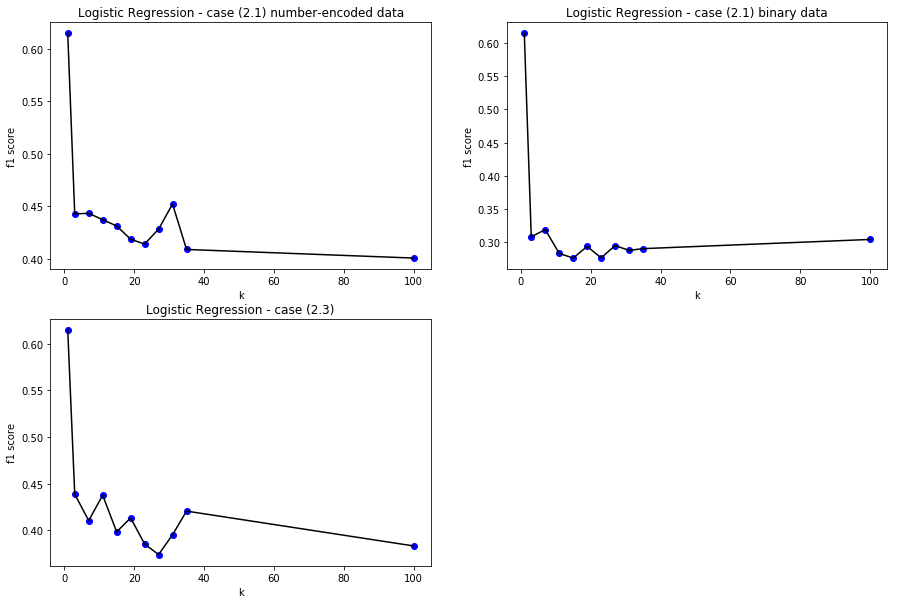

In [29]:
# visualize how f1 score depends on k
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Logistic Regression - case (2.1) number-encoded data')

plt.plot(k_values, f1_scores1, 'bo', k_values, f1_scores1, 'k')
plt.ylabel('f1 score')
plt.xlabel('k')

ax = fig.add_subplot(2, 2, 2)
ax.set_title('Logistic Regression - case (2.1) binary data')

plt.plot(k_values, f1_scores_bin, 'bo', k_values, f1_scores_bin, 'k')
plt.ylabel('f1 score')
plt.xlabel('k')

ax = fig.add_subplot(2, 2, 3)
ax.set_title('Logistic Regression - case (2.3)')

plt.plot(k_values, f1_scores2, 'bo', k_values, f1_scores2, 'k')
plt.ylabel('f1 score')
plt.xlabel('k')

In [30]:
# pickle f1 scores 2.1
outfile = open('../../data/ARX/multi-class-edu/LR_f1_scores', 'wb')
pickle.dump(f1_scores1, outfile)
outfile.close()

In [31]:
# pickle f1 scores 2.3
outfile = open('../../data/ARX/without-contin-hie/LR_f1_scores', 'wb')
pickle.dump(f1_scores2, outfile)
outfile.close()